In [1]:
import cv2
import numpy as np
import sys
import os 
from pdf2image import convert_from_path
import easyocr
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist

In [2]:
# pdf 路徑
pdf_path = "..\\..\\data\\pdf\\BoredPile\\plan_all.pdf"
# csv 路徑
csv_path = "pile.csv"
# 輸出路徑
output_path = "result.xml"

### 第一階段用ocr抓型號、樁徑

* pdf 轉 png

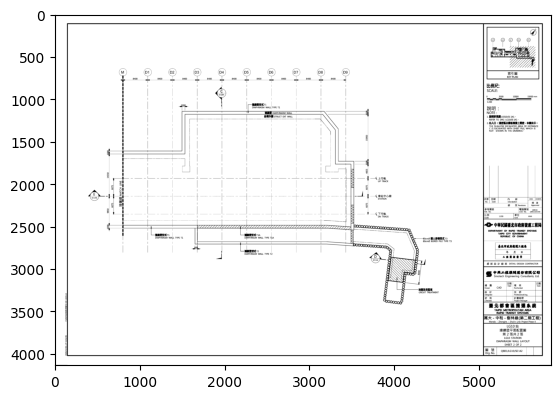

In [3]:
images = convert_from_path(pdf_path, dpi =500, poppler_path = r'C:\\Users\\jimmy\Downloads\\Release-24.02.0-0\\poppler-24.02.0\\Library\\bin')

cv2_img = cv2.cvtColor(np.asarray(images[0]),cv2.COLOR_RGB2BGR)

# ROTATE_90_COUNTERCLOCKWISE
cv2_img = cv2.rotate(cv2_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold (img_gray, 240, 255, 0)
img_blur = cv2.GaussianBlur(img_th, (5, 5), 0)
plt.imshow(img_th, cmap='gray')

* easyocr

In [12]:
reader = easyocr.Reader(['en'])
bounds = reader.readtext(img_th, detail=1)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [20]:
import re
for bound in bounds:
    match = re.match(r'(\S+)cm(.*)BORED PILE TYPE (\S+)', bound[1])
    if match:
        diameter = re.sub(r'O', '0', match.group(1))
        type= match.group(3)
        break

print(diameter, type)
        
        

80 T3


* 篩選關鍵字，獲得型號

In [22]:
response = []
for word in bounds:
    if word[1].find("BORED PILE") > -1:
        print(word[1])
        response.append(word[1])



8Ocm@ BORED PILE TYPE T3


In [16]:
csv_data = pd.read_csv(csv_path)

print(csv_data)

coordinates = csv_data[['x_coor', 'y_coor']].values

p1 = np.array([coordinates[0][0], coordinates[0][1]])
p2 = np.array([coordinates[1][0], coordinates[1][1]])

dist = cdist([p1], [p1, p2], 'euclidean')
print(dist)

      x_coor    y_coor  Unnamed: 2
0    134.112 -20.00720         NaN
1    134.210 -19.21320         NaN
2    130.725 -20.91140         NaN
3    130.629 -21.69240         NaN
4    130.532 -22.47350         NaN
..       ...       ...         ...
99   116.991  -4.26220         NaN
100  116.193  -4.20601         NaN
101  115.395  -4.14983         NaN
102  114.597  -4.09365         NaN
103  113.799  -4.03746         NaN

[104 rows x 3 columns]
[[0.       0.800025]]


In [3]:
from scipy.spatial import KDTree
from collections import Counter
def find_most_common_distance(csv_file_path):
    # 讀取 CSV 文件
    data = pd.read_csv(csv_file_path)

    # numbers of rows
    number_of_rows = data.shape[0]
    
    # 檢查數據中是否存在 x_coor 和 y_coor 欄位
    if 'x_coor' not in data.columns or 'y_coor' not in data.columns:
        return "CSV 文件中必須包含 'x_coor' 和 'y_coor' 欄位。"
    
    # 建立 KDTree 用於快速尋找最近點
    tree = KDTree(data[['x_coor', 'y_coor']])
    
    # 查詢最近的兩個鄰居的距離和索引
    distances, _ = tree.query(data[['x_coor', 'y_coor']], k=3)
    
    # 提取最近和次近鄰居的距離
    nearest_distances = distances[:, 1]
    second_nearest_distances = distances[:, 2]
    
    # 結合所有距離
    all_distances = np.concatenate((nearest_distances, second_nearest_distances))
    
    # 四捨五入距離以處理浮點數精確問題
    rounded_distances = np.round(all_distances, decimals=3)
    
    # 使用 Counter 統計最常見的距離
    distance_counts = Counter(rounded_distances)
    most_common_distance, _ = distance_counts.most_common(1)[0]
    
    return number_of_rows, most_common_distance

In [5]:
number, most_distance = find_most_common_distance(csv_path)
print(number, most_distance)

104 0.8


### 第二階段用 csv 抓繫樑行進米、排樁根數、樁徑

In [9]:
csv_data = pd.read_csv(csv_path, encoding='cp1252')

# Extract the coordinates
coordinates = csv_data[['x_coor', 'y_coor']].values


# Calculate the pairwise distances
distances = cdist(coordinates, coordinates, metric='euclidean')

# Initialize the path and visited nodes
n_points = len(coordinates)
visited = np.zeros(n_points, dtype=bool)
path = [0]  # Start from the first point
visited[0] = True

# Greedy algorithm to find the nearest neighbor path
for _ in range(1, n_points):
    last_point = path[-1]
    nearest_neighbor = np.argmin(distances[last_point, ~visited])
    next_point = np.where(~visited)[0][nearest_neighbor]
    path.append(next_point)
    visited[next_point] = True

# Add the first point at the end to complete the loop
path.append(path[0])

# Calculate the total length of the path
# total_length = sum(
#     np.linalg.norm(coordinates[path[i]] - coordinates[path[i + 1]])
#     for i in range(n_points) if np.linalg.norm(coordinates[path[i]] - coordinates[path[i + 1]]) <= 4
# )
total_length = n_points * most_distance

print(f'The total number of bordpile is {n_points}')
print(f'The total length of the path is {total_length:.2f}')


The total number of bordpile is 104
The total length of the path is 83.20


#### 成果視覺化

<Figure size 640x480 with 0 Axes>

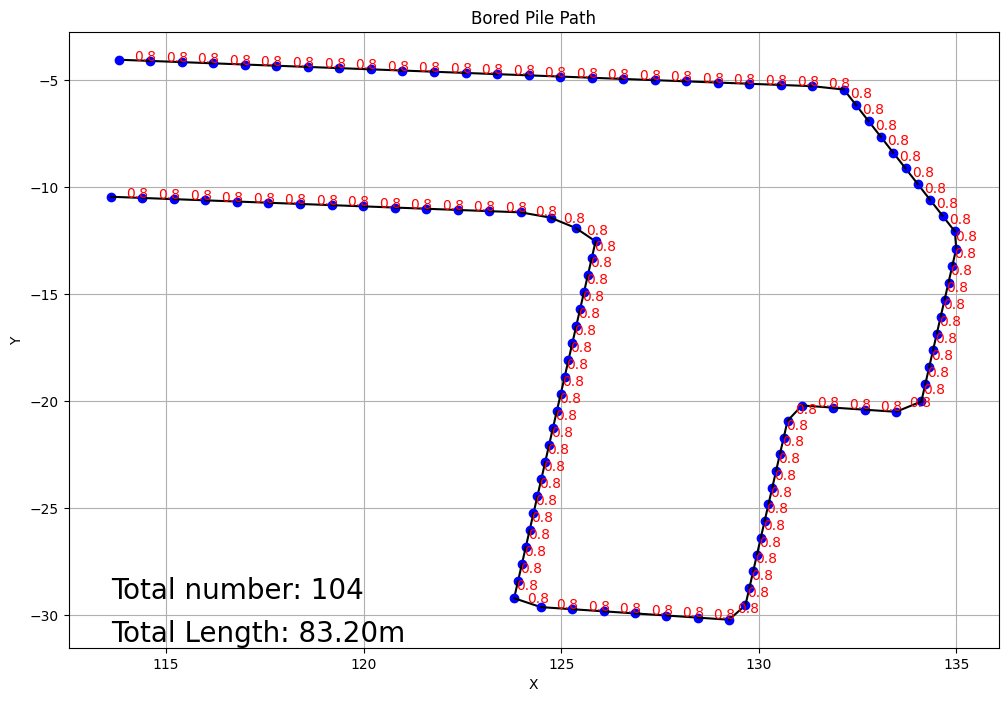

In [10]:
# clear the plot
plt.clf()
# Plot the path with segment lengths
plt.figure(figsize=(12, 8))
# plt.plot(coordinates[path, 0], coordinates[path, 1], marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bored Pile Path')
plt.grid(True)

segment_lengths = [
    np.linalg.norm(coordinates[path[i]] - coordinates[path[i + 1]])
    for i in range(n_points)
]

# Annotate each segment with its length
for i in range(n_points):
    x_mid = (coordinates[path[i], 0] + coordinates[path[i + 1], 0]) / 2
    y_mid = (coordinates[path[i], 1] + coordinates[path[i + 1], 1]) / 2
    plt.plot(coordinates[path[i], 0], coordinates[path[i], 1], color='blue', marker='o')
    # plot the nearest connect line except the distance greater than 4
    if np.linalg.norm(coordinates[path[i]] - coordinates[path[i + 1]]) <= 4:
        plt.plot([coordinates[path[i], 0], coordinates[path[i + 1], 0]],
                 [coordinates[path[i], 1], coordinates[path[i + 1], 1]], color='black')
        plt.text(x_mid, y_mid, f'{segment_lengths[i]:.1f}', color='red')

# plot the total length in the left bottom corner
plt.text(min(coordinates[:, 0]), min(coordinates[:, 1]) - 1, f'Total Length: {total_length:.2f}m', color='black', fontdict={'size': 20})
plt.text(min(coordinates[:, 0]), min(coordinates[:, 1]) + 1, f'Total number: {n_points}', color='black', fontdict={'size': 20})

plt.show()